In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from riskyneuroarousal.utils.load_data import (load_behavioral_data, load_pupil_data)
%load_ext rpy2.ipython

#### Load the data
We load the preprocessed, trial data aligned to the response time. Trials are 4 seconds.

In [3]:
behav = load_behavioral_data(min_RT = 0.2)
pupil_data = load_pupil_data()
data = pupil_data.merge(behav, on=["sub", "trial"])

In [5]:
equalIndiff_rows = data["condition"] == "equalIndifference"
data.loc[equalIndiff_rows, "dist_from_indiff"] = np.abs(data[equalIndiff_rows]["gain"] - 1.6*data[equalIndiff_rows]["loss"]) / np.square(1 + 1.6**2)
equalRange_rows = data["condition"] == "equalRange"
data.loc[equalRange_rows, "dist_from_indiff"] = np.abs(data[equalRange_rows]["gain"] - 1*data[equalRange_rows]["loss"]) / np.square(1 + 1)

#### Plot the pupil data for each condition

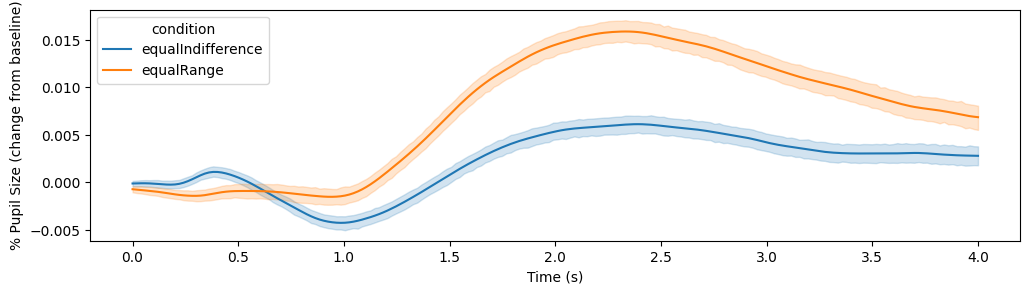

In [6]:
plt.figure(figsize=(12, 3))
sns.lineplot(data=data, x='timebin', y='ps_preprocessed', hue='condition')
# plt.title('Equal Range (Low-Reward)')
plt.xlabel('Time (s)')
plt.ylabel('% Pupil Size (change from baseline)')
plt.show()

### Sample every 0.5 seconds pupil

In [7]:
timebins = np.arange(0, 4, 0.25)
pupil_response = []
for timebin in timebins:
    decision_pupil = data.query(f"timebin > {timebin} & timebin < {timebin + 0.5}").groupby(["sub", "condition", "gain", "loss", "accept", "dist_from_indiff", "RT"])[["ps_preprocessed", "blink"]].mean().reset_index()
    decision_pupil["timebin"] = timebin
    pupil_response.append(decision_pupil)
pupil_response = pd.concat(pupil_response)

#### Modeling timebins of pupil size
We will model the pupil size as a function of the accept, blink, and condition. We want to observe the effect of the accept, gain, and loss on pupil size. Furthermore, we want to eliminate the effect of blink and condition

In [8]:
%%R -i pupil_response
library(mgcv)
library(lme4)
library(lmerTest)

/Users/gustxsr/Documents/Stanford/PoldrackLab/github/riskyneuroarousal/.venv/lib/python3.12/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


Loading required package: nlme
This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.
Loading required package: Matrix

Attaching package: ‘lme4’

The following object is masked from ‘package:nlme’:

    lmList


Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step



In [9]:
%%R
# loop through timebins
timebins <- c()
coefficient_pvalues <- c()
coefficient_name <- c()
coefficient_estimate <- c()
condition_list <- c()
for (tb in unique(pupil_response$timebin)) {
    # for each timebin, run a linear mixed effects model of ps_preprocessed
    model_indiff = lmer(ps_preprocessed ~ gain + loss + dist_from_indiff + blink + (1 | sub), data=pupil_response[pupil_response$timebin == tb & pupil_response$condition == 'equalIndifference', ])
    model_equal = lmer(ps_preprocessed ~ gain + loss + dist_from_indiff + blink + (1 | sub), data=pupil_response[pupil_response$timebin == tb & pupil_response$condition == 'equalRange', ])
    # save the coefficients and pvalues in a list
    fixed_effects <- summary(model_indiff)$coefficients
    # Loop through fixed effects
    for (i in 1:nrow(fixed_effects)) {
        effect_name <- rownames(fixed_effects)[i]  # Name of the fixed effect
        estimate <- fixed_effects[i, "Estimate"]  # Estimate of the fixed effect
        p_value <- fixed_effects[i, "Pr(>|t|)"]   # p-value of the fixed effect
        coefficient_pvalues <- c(coefficient_pvalues, p_value)
        coefficient_name <- c(coefficient_name, effect_name)
        coefficient_estimate <- c(coefficient_estimate, estimate)
        timebins <- c(timebins, tb)
        condition_list <- c(condition_list, 'equalIndifference')
    }

    fixed_effects <- summary(model_equal)$coefficients
    for (i in 1:nrow(fixed_effects)) {
        effect_name <- rownames(fixed_effects)[i]  # Name of the fixed effect
        estimate <- fixed_effects[i, "Estimate"]  # Estimate of the fixed effect
        p_value <- fixed_effects[i, "Pr(>|t|)"]   # p-value of the fixed effect
        coefficient_pvalues <- c(coefficient_pvalues, p_value)
        coefficient_name <- c(coefficient_name, effect_name)
        coefficient_estimate <- c(coefficient_estimate, estimate)
        timebins <- c(timebins, tb)
        condition_list <- c(condition_list, 'equalRange')
    }
}

In [10]:
%%R -o all_sub_pupil_coef
# put them into a dataframe
all_sub_pupil_coef <- data.frame(timebin = timebins, 
                            name = coefficient_name, 
                            estimate = coefficient_estimate, 
                            pvalue = coefficient_pvalues, 
                            condition = condition_list)

In [11]:
equalRange_rows = all_sub_pupil_coef["condition"] == 'equalRange'
equalIndifference_rows = all_sub_pupil_coef["condition"] == 'equalIndifference'

all_sub_pupil_coef["pvalue"] = stats.false_discovery_control(all_sub_pupil_coef['pvalue'].values, method = "by")

In [12]:
timebins = all_sub_pupil_coef['timebin'].unique()
names = ["gain", "loss", "dist_from_indiff"]

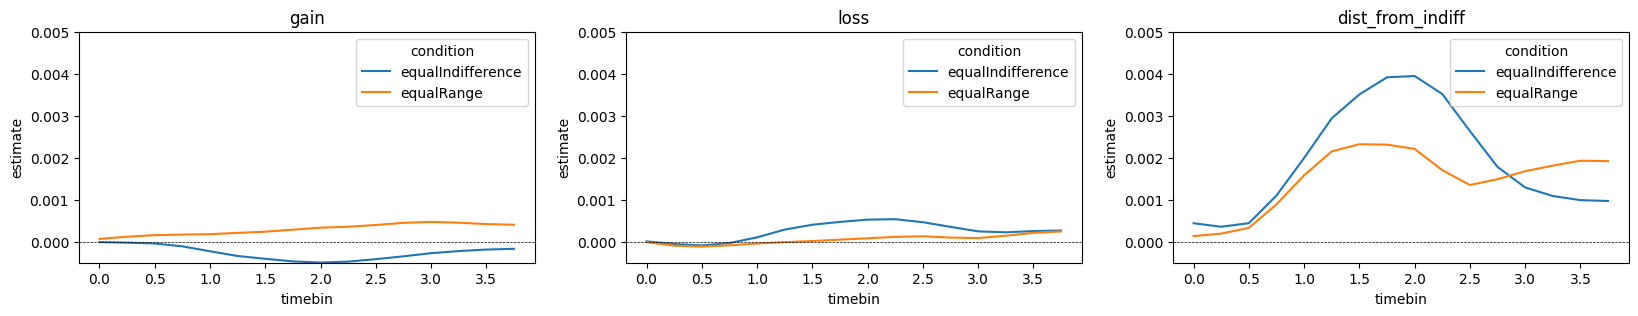

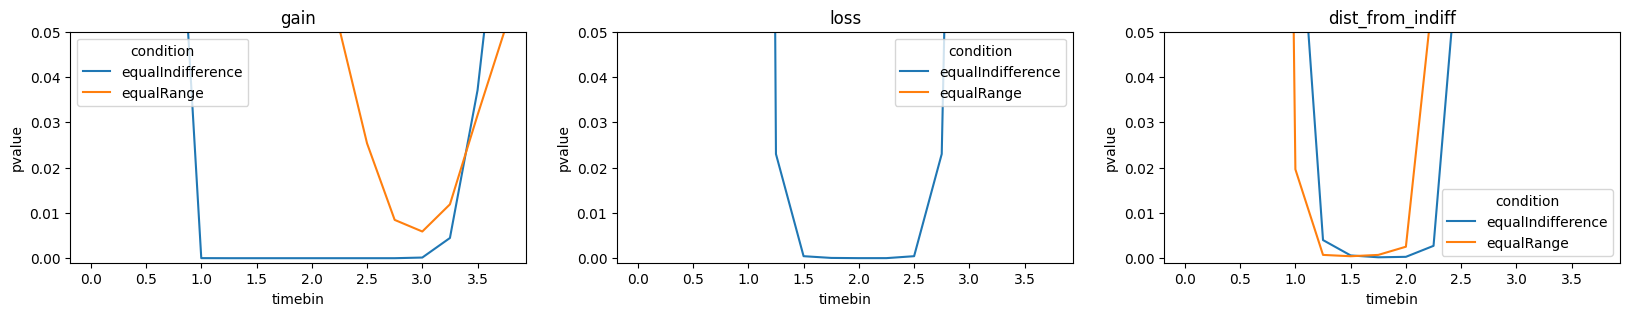

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(20, 3))
for name, ax in zip(names, axs.flatten()):
    sns.lineplot(data=all_sub_pupil_coef.query(f"name == '{name}'"), x='timebin', y='estimate', hue = 'condition', ax=ax)
    # add a horizontal line at 0
    ax.axhline(0, ls="--", c="k", lw=0.5)
    ax.set_title(name)
    ax.set_ylim(-0.0005, 0.005)

fig, axs = plt.subplots(1, 3, figsize=(20, 3))
for name, ax in zip(names, axs.flatten()):
    sns.lineplot(data=all_sub_pupil_coef.query(f"name == '{name}'"), x='timebin', y='pvalue', hue = 'condition', ax=ax)
    ax.set_title(name)
    ax.set_ylim(-0.001, 0.05)

**Findings:**
- For High Reward condition, Gains significantely decrease pupil size approximately 250ms before the response time. 
- For Low Reward condition, Gains significantely increase pupil size approximately 250ms before the response time (but more starting on response time). 
- For High Reward condition, Losses significantely increase pupil size approximately 250ms before the response time (also they increase pupil more than gains do). 
- For Low Reward condition, Losses dont have a significant effect on pupil size.

## SCRAP
#### Relation of pupil response to behavior
What is the source of the pupil response? For each subject, compute the estimate of the accept, gain, and loss for each timebin 100 ms around the response time. 

In [33]:
%%R
timebins <- c()
coefficient_pvalues <- c()
coefficient_name <- c()
coefficient_estimate <- c()
sub_list <- c()
for (tb in unique(pupil_response$timebin)) {
    # skip tb lower than 1.3 and higher than 1.5
    if (tb < 1.5 | tb > 2.5) {
        next
    }
    # loop through each sub
    for (sub in unique(pupil_response$sub)) {
        # for each timebin, run a linear mixed effects model of ps_preprocessed predicted by accept*condition + blink*condition + (sub|1)
        model = lm(ps_preprocessed ~ gain + loss + blink + dist_from_indiff, data=pupil_response[pupil_response$timebin == tb & pupil_response$sub == sub, ])
        # save the coefficients and pvalues in a list
        fixed_effects <- summary(model)$coefficients
        # Loop through fixed effects
        for (i in 1:nrow(fixed_effects)) {
            effect_name <- rownames(fixed_effects)[i]  # Name of the fixed effect
            estimate <- fixed_effects[i, "Estimate"]  # Estimate of the fixed effect
            p_value <- fixed_effects[i, "Pr(>|t|)"]   # p-value of the fixed effect
            coefficient_pvalues <- c(coefficient_pvalues, p_value)
            coefficient_name <- c(coefficient_name, effect_name)
            coefficient_estimate <- c(coefficient_estimate, estimate)
            timebins <- c(timebins, tb)
            sub_list <- c(sub_list, sub)
        }
    }
}

In [34]:
%%R -o sub_pupil_coef
# put them into a dataframe
sub_pupil_coef <- data.frame(timebin = timebins, 
                            name = coefficient_name, 
                            estimate = coefficient_estimate, 
                            pvalue = coefficient_pvalues,
                            sub = sub_list)

In [35]:
sub_pupil_coef = sub_pupil_coef.query("name == 'dist_from_indiff' | name == 'gain' | name == 'loss'").groupby(['sub', 'name'])['estimate'].mean().reset_index()

In [37]:
sub_pupil_coef.to_csv("pupil_coefs.csv")

In [19]:
# Load the data for DDM fits
all_params_fit = pd.read_csv("../../data/ddm_fits.csv")[["param_name", "mean", "sub", "condition"]]
# We will include lambda as a parameter, which is the ratio of the drift rate towards gain to the drift rate towards loss
lmbda = {}
lmbda["param_name"] = "lambda"
lmbda["mean"] = np.abs(all_params_fit.query("param_name == 'v_loss'")["mean"].values / all_params_fit.query("param_name == 'v_gain'")["mean"].values)
lmbda["sub"] = all_params_fit.query("param_name == 'v_loss'")["sub"].values
lmbda["condition"] = all_params_fit.query("param_name == 'v_loss'")["condition"].values
lmbda = pd.DataFrame(lmbda)
all_params_fit = pd.concat([all_params_fit, lmbda])
# PT lambda as well

# Load the data for accept rates
behav_data = pd.read_csv('../../data/behavioral_data.csv')
accept_rate = behav_data.groupby(["sub", "condition"])["accept"].mean().reset_index()
accept_rate = accept_rate.merge(all_params_fit, on=["sub", "condition"])

In [20]:
# sort accept rate by sub
accept_rate = accept_rate.sort_values(by="sub")
sub_pupil_coef = sub_pupil_coef.sort_values(by="sub")

In [72]:
p_values, t_values = [], []
for param1 in sub_pupil_coef["name"].unique():
    for param2 in accept_rate["param_name"].unique():
        p = stats.pearsonr(sub_pupil_coef.query(f"name == '{param1}'")["estimate"].values, 
                           accept_rate.query(f"param_name == '{param2}'")["mean"].values)
        
        p_values.append(p.pvalue)
        t_values.append(p.correlation)
p_values = stats.false_discovery_control(p_values)
i = 0
for param1 in sub_pupil_coef["name"].unique():
    for param2 in accept_rate["param_name"].unique():
        if p_values[i] < 0.05:
            print(param1, param2)
            print(t_values[i], p_values[i])
            print()
        i += 1

gain z
-0.3787236443498543 0.037949317116755074

loss z
0.4331838302123658 0.017094255704137695



**Findings:**
- A decrease in pupil size due to gains is associated with an increase in the response bias. 
- An increase in pupil size due to losses is associated with an increase in the response bias.

In [26]:
acceptance_sub = accept_rate.groupby("sub")["accept"].mean().reset_index()["accept"].values
for param in sub_pupil_coef["name"].unique():
    p = stats.pearsonr(sub_pupil_coef.query(f"name == '{param}'")["estimate"].values, acceptance_sub)
    if p.pvalue < 0.05:
        print(param)
        print(p)

gain
PearsonRResult(statistic=np.float64(-0.4796149111505896), pvalue=np.float64(0.00024295136336071037))
loss
PearsonRResult(statistic=np.float64(0.4871916502137617), pvalue=np.float64(0.0001869070107981044))


**Findings:** 
- As previous research has found, the pupil response is correlated with the probability of accepting a gamble. 

#### Loss averse body, loss averse behavior?


In [43]:
pupil_loss_aversion = sub_pupil_coef.query("name == 'loss'")["estimate"].values + sub_pupil_coef.query("name == 'gain'")["estimate"].values
gain = sub_pupil_coef.query("name == 'gain'")["estimate"].values
loss = sub_pupil_coef.query("name == 'loss'")["estimate"].values
subs = sub_pupil_coef.query("name == 'loss'")["sub"].values
condition = accept_rate.query("param_name == 'lambda'")["condition"].values
lmbd = accept_rate.query("param_name == 'lambda'")["mean"].values
starting_point = accept_rate.query("param_name == 'z'")["mean"].values

loss_aversion = pd.DataFrame({"pupil_loss_aversion": pupil_loss_aversion, "sub": subs, "condition": condition, "lmbd": lmbd, "starting_point": starting_point, "gain": gain, "loss": loss})

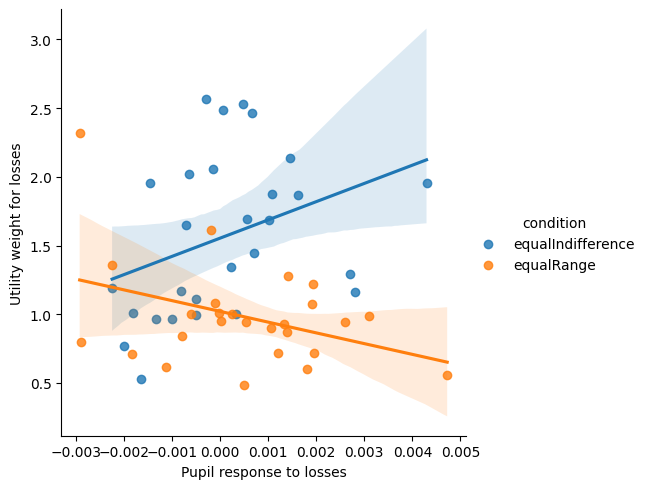

In [44]:
sns.lmplot(data=loss_aversion, x='pupil_loss_aversion', y='lmbd', hue='condition')
plt.xlabel("Pupil response to losses")
plt.ylabel("Utility weight for losses")
plt.show()

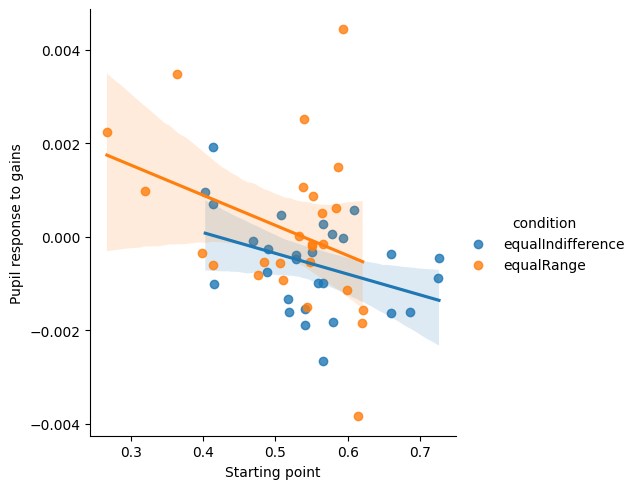

In [47]:
sns.lmplot(data=loss_aversion, x='starting_point', y='gain', hue='condition')
plt.xlabel("Starting point")
plt.ylabel("Pupil response to gains")
plt.show()

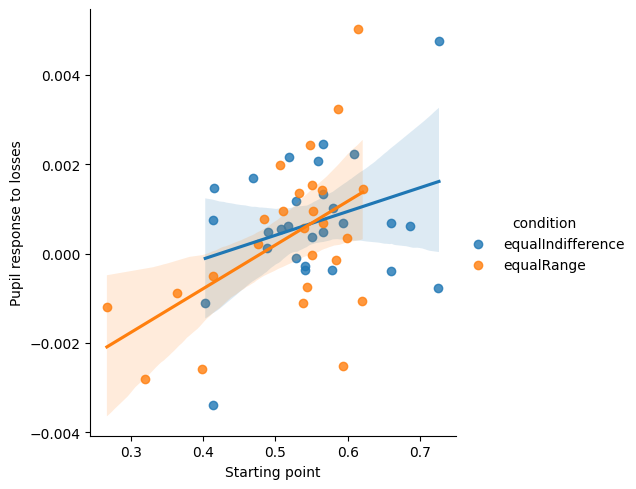

In [48]:
sns.lmplot(data=loss_aversion, x='starting_point', y='loss', hue='condition')
plt.xlabel("Starting point")
plt.ylabel("Pupil response to losses")
plt.show()

In [85]:
results = pd.DataFrame({"acceptance": acceptance_sub, "estimate": sub_pupil_coef.query("name == 'accept'")["estimate"].values, "sub" : sub_pupil_coef.query("name == 'accept'")["sub"].values, "v_loss" : accept_rate.query("param_name == 'v_loss'")["mean"].values})

# behav_data has the conditions for each sub
behav_data.groupby("sub")["condition"].unique()
# get the condition for each unique sub
sub_cond = behav_data[["sub", "condition"]].drop_duplicates().reset_index(drop=True)
results = results.merge(sub_cond, on="sub")

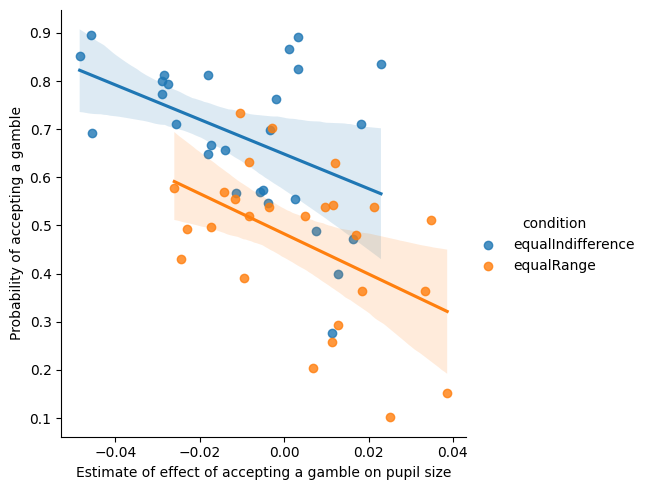

In [84]:
sns.lmplot(data=results, x='estimate', y='acceptance', hue='condition')
# X-Label is "Estimate of effect of accepting a gamble"
plt.xlabel("Estimate of effect of accepting a gamble on pupil size")
plt.ylabel("Probability of accepting a gamble")
plt.show()

In [ ]:
# Dont call it effect of accepting (Estimate of relation between accepting and pupil size) (Non causal way to describe it)

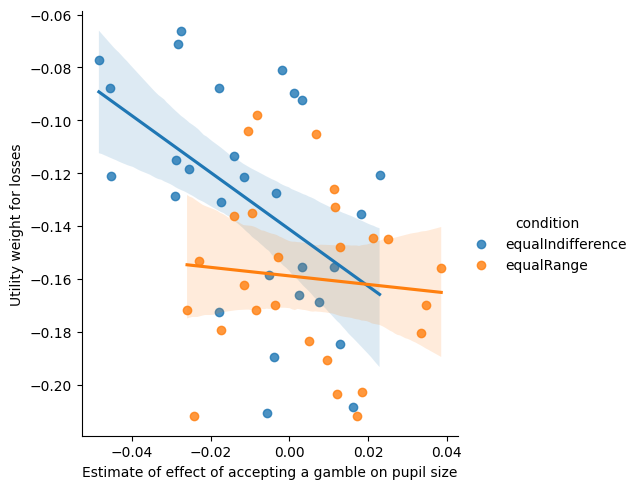

In [88]:
sns.lmplot(data=results, x='estimate', y='v_loss', hue='condition')
# X-Label is "Estimate of effect of accepting a gamble"
plt.xlabel("Estimate of effect of accepting a gamble on pupil size")
plt.ylabel("Utility weight for losses")
plt.show()

Compute VIF for the model with vs without accept and see if it substantially inflates the VIF. If it doesnt we can use the whole model. 